Saving 11.jpg to 11.jpg


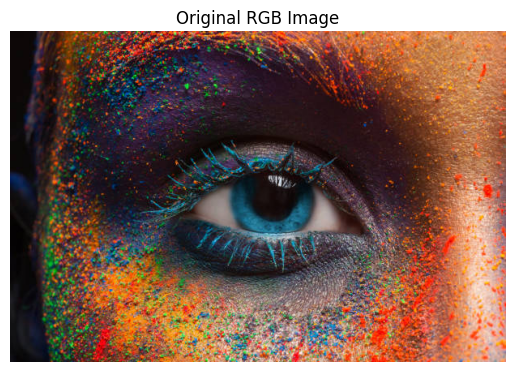

Image Dimensions: Height=408, Width=612, Channels=3
Total Pixels: 249696
Black Pixel Area (Count of black pixels): 192110


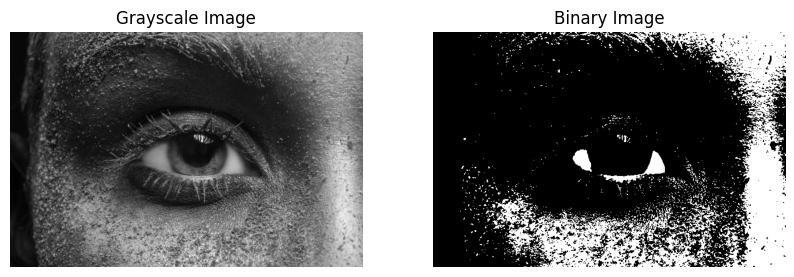

In [1]:
# Task 1: Image Manipulation
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Upload and Read Image
from google.colab import files
uploaded = files.upload()

image_path = list(uploaded.keys())[0]
img_bgr = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 1. Display the image
plt.imshow(img_rgb)
plt.title("Original RGB Image")
plt.axis('off')
plt.show()

# 2. Extract image size (height, width, channels)
height, width, channels = img_rgb.shape
print(f"Image Dimensions: Height={height}, Width={width}, Channels={channels}")

# 3. Calculate total number of pixels
total_pixels = height * width
print(f"Total Pixels: {total_pixels}")

# 4. Convert to Grayscale
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
cv2.imwrite("grayscale_image.jpg", img_gray)

# 5. Convert Grayscale to Binary using a threshold
_, img_binary = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
cv2.imwrite("binary_image.jpg", img_binary)

# 6. Count the area of black pixels in binary image
black_pixel_area = np.sum(img_binary == 0)
print(f"Black Pixel Area (Count of black pixels): {black_pixel_area}")

# Show grayscale and binary images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_gray, cmap='gray')
axs[0].set_title("Grayscale Image")
axs[0].axis('off')

axs[1].imshow(img_binary, cmap='gray')
axs[1].set_title("Binary Image")
axs[1].axis('off')

plt.show()


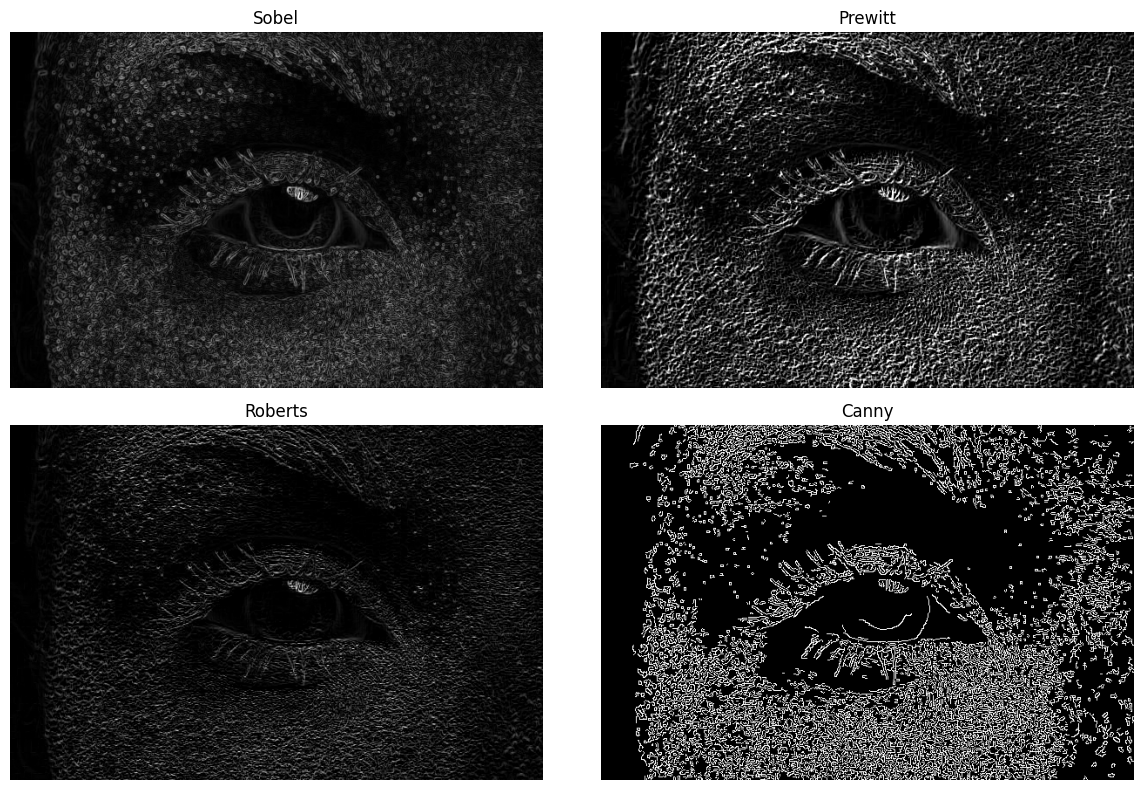

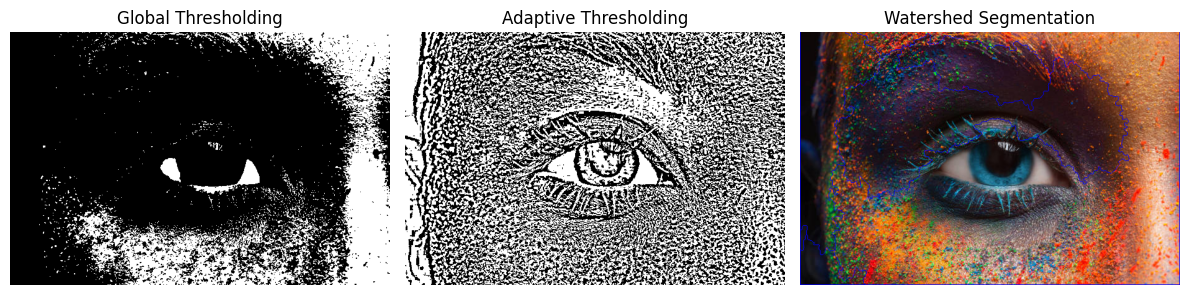

In [2]:
# Task 2: Image Edge Detection and Segmentation

# 1. Edge Detection

# i. Sobel Operator
sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)

# ii. Prewitt Operator (manually using kernels)
kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
prewittx = cv2.filter2D(img_gray, -1, kernelx)
prewitty = cv2.filter2D(img_gray, -1, kernely)
prewitt = cv2.add(prewittx, prewitty)

# iii. Roberts Cross Operator
roberts_cross_x = np.array([[1, 0], [0, -1]])
roberts_cross_y = np.array([[0, 1], [-1, 0]])
robertsx = cv2.filter2D(img_gray, -1, roberts_cross_x)
robertsy = cv2.filter2D(img_gray, -1, roberts_cross_y)
roberts = cv2.add(robertsx, robertsy)

# iv. Canny Edge Detector
canny = cv2.Canny(img_gray, 100, 200)

# Display all edge-detected images
titles = ['Sobel', 'Prewitt', 'Roberts', 'Canny']
images = [sobel, prewitt, roberts, canny]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 2. Image Segmentation

# i. Global Thresholding
_, global_thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

# ii. Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                        cv2.THRESH_BINARY, 11, 2)

# iii. Canny for Segmentation (already done above as canny)

# iv. Region-Based Segmentation using Watershed
img_copy = img_bgr.copy()
gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove noise
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labeling
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply Watershed
markers = cv2.watershed(img_copy, markers)
img_copy[markers == -1] = [255, 0, 0]  # Red boundary

# Show all segmentation results
titles = ['Global Thresholding', 'Adaptive Thresholding', 'Watershed Segmentation']
images = [global_thresh, adaptive_thresh, img_copy[..., ::-1]]  # Convert BGR to RGB

plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(images[i], cmap='gray' if i < 2 else None)
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
